In [2]:
import re
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import random
from joint_stemmer_postagger import TurkishStemmerPOSTagger
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from IPython.display import Markdown, display
import _pickle as pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.manifold import TSNE
from networkx.algorithms import community
import pandas as pd
from IPython.display import HTML, display

c:\users\dell\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
def printmd(string):
    """
    Print markdown strings
    """
    display(Markdown(string))

def asciify_txt(txt):
    """
    Convert non-ascii Turkish characters (ı, ş , ğ) to their ascii forms (i, s, g)
    :param txt: String variable tobe asciified
    :return: Asciified string
    """
    asciified = txt
    asciified = asciified.replace("ı", "i")
    asciified = asciified.replace("ü", "u")
    asciified = asciified.replace("ş", "s")
    asciified = asciified.replace("ö", "o")
    asciified = asciified.replace("ğ", "g")
    asciified = asciified.replace("ç", "c")
    asciified = asciified.replace("İ", "I")
    asciified = asciified.replace("Ü", "U")
    asciified = asciified.replace("Ş", "S")
    asciified = asciified.replace("Ö", "O")
    asciified = asciified.replace("Ğ", "G")
    asciified = asciified.replace("Ç", "C")
    return asciified

In [4]:
# READ TURKISH STOP WORDS FROM FILE
stop_words = []
with open("resources/nlp/turkish/stopwords.txt", "r", encoding="UTF-8") as f:
    for line in f:
        stop_words.append(line.strip())
ascified_stop_words = []
for stop_word in stop_words:
    ascified_stop_words.append(asciify_txt(stop_word))

In [5]:
# READ SEMEVAL RESTAURANT DATASET
# Preprocessing steps: 
# (1) Tokenization, 
# (2) Lowercase all characters
# (3) Stop word removal
# (4) Non-word removal (punctuations and numbers)
# (5) Naive rule based stemming for Turkish 
# (6) Asciificaiton

# FILE PATHS
raw_data_path = "resources/data/restaurant_sentence_level.txt"
preprocesed_data_path = "resources/data/restaurant_sentence_level_preprocessed.txt"

# Create tokenizer and stemmer objects
tokenizer = TweetTokenizer()
stemmer = TurkishStemmerPOSTagger.create_from_existed_model()

raw_reviews = []
preprocessed_reviews = []
first_level_labels = []
second_level_labels = []

# IF PREPROCESSED FILE IS CREATED BEFORE, USE IT TO READ DATASET
if os.path.isfile(preprocesed_data_path):
    with open(preprocesed_data_path, "r", encoding="UTF-8") as f:
        for line in f:
            splits = line.strip().split("\t")
            if len(splits) != 3:
                print("Error in line: {}".format(line))
            review = splits[0]
            raw_reviews.append(review)
            preprocessed_review = splits[1]
            preprocessed_reviews.append(preprocessed_review)
            labels = list(set(splits[2].split(" ")))
            first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
            second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
# OTHERWISE APPLY PREPROCESSING STEPS TO RAW DATA THEN SAVE IT FOR FURTHER USE
else:
    with open(preprocesed_data_path, "w", encoding="UTF-8") as w:
        with open(raw_data_path, "r", encoding="UTF-8") as f:
            for line in f:
                splits = line.strip().split("\t")
                # Check if review has a label
                if len(splits) == 2:
                    review = splits[0].strip()
                    review = re.sub("[\t\r\n ]+", " ", review)
                    raw_reviews.append(review)
                    review = review.lower()
                    tokens = tokenizer.tokenize(review)
                    tokens = [token for token in tokens if re.match(r"^[a-zA-ZİĞŞÜÇÖığüöçş]+$", token) and token not in stop_words]
                    stems = stemmer.get_stems(tokens)
                    stems = [asciify_txt(stem) for stem in stems if asciify_txt(stem) not in ascified_stop_words]
                    preprocessed_review = " ".join(stems)
                    preprocessed_reviews.append(preprocessed_review)
                    labels = list(set(splits[1].split(" ")))
                    first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
                    second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
                    w.write("{}\t{}\t{}\n".format(review, preprocessed_review, " ".join(labels)))


** Number of reviews: ** 1228

** LABELS: ** 
 - DRINKS
STYLE_OPTIONS
 - SERVICE
GENERAL
 - FOOD
PRICES
 - RESTAURANT
MISCELLANEOUS
 - AMBIENCE
GENERAL
 - FOOD
STYLE_OPTIONS
 - DRINKS
PRICES
 - DRINKS
QUALITY
 - RESTAURANT
PRICES
 - LOCATION
GENERAL
 - RESTAURANT
GENERAL
 - FOOD
QUALITY  
 - ** Number of second level labels: ** 12

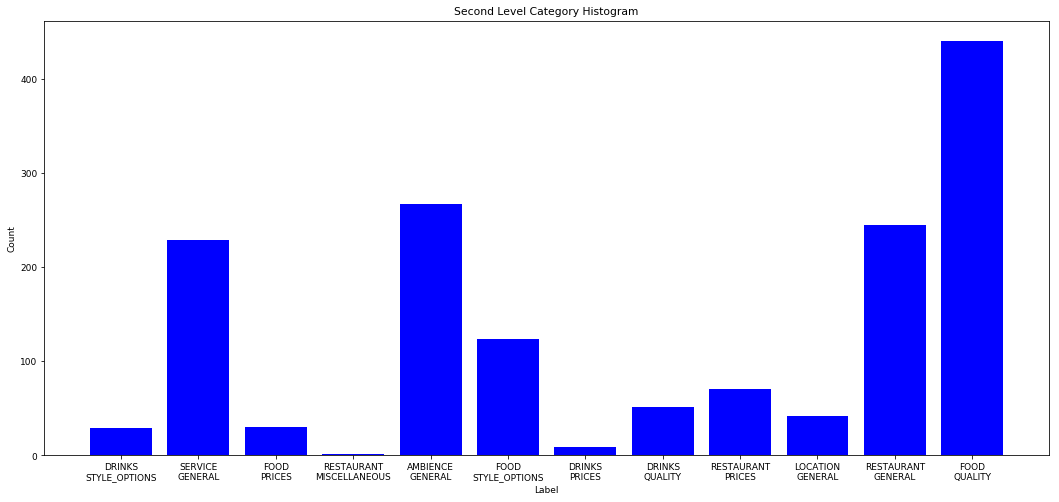

In [89]:
# VISUALIZE DATA STATISTICS
printmd("** Number of reviews: ** {}".format(len(first_level_labels)))


# PLOT FIRST LEVEL LABELS HISTOGRAM
# plt.bar(first_level_labels_set, first_level_counts_set, width=0.80, color='b')
# plt.title("First Level Category Histogram")
# plt.ylabel("Count")
# plt.xlabel("Label")
# ax.set_xticks([l for l in first_level_labels_set])
# ax.set_xticklabels(first_level_labels_set)
# plt.show()

# SECOND LEVEL LABELS
matplotlib.rcParams.update({'font.size': 9})
second_level_label_counts = {}
for cur_labels1, cur_labels2 in zip(first_level_labels, second_level_labels):
        for label1, label2 in zip(cur_labels1, cur_labels2):
            label = label1 + "\n" + label2
            if label not in second_level_label_counts:
                second_level_label_counts[label] = 1
            else:
                second_level_label_counts[label] += 1
second_level_labels_set = [label for label, _ in second_level_label_counts.items()]
second_level_counts_set = [count for _, count in second_level_label_counts.items()]
                

# PRINT LABELS STATS
printmd("** LABELS: ** \n - {}  \n - ** Number of second level labels: ** {}"
        .format("\n - ".join(second_level_labels_set), len(second_level_labels_set)))


# PLOT SECOND LEVEL LABELS HISTOGRAM
fig, ax = plt.subplots(figsize=(18, 8))
plt.bar(second_level_labels_set, second_level_counts_set, width=0.80, color='b')

plt.title("Second Level Category Histogram")
plt.ylabel("Count")
plt.xlabel("Label")
ax.set_xticks([l for l in second_level_labels_set])
ax.set_xticklabels(second_level_labels_set)
plt.show()

In [7]:
# ALL LISTS BELOW SHOULD BE IN EQUAL LENGTH
assert len(raw_reviews) == len(preprocessed_reviews) == len(first_level_labels) == len(second_level_labels)

In [94]:
# PRINT AN EXAMPLE REVIEW
example_review_index = 105

printmd("**Raw review:** {}".format(raw_reviews[example_review_index]))
printmd("**Preprocessed review:** {}".format(preprocessed_reviews[example_review_index]))
printmd("**Labels:**\n - {}".format("\n - ".join(label1 + "/" + label2 for label1, label2
                                                              in zip(first_level_labels[example_review_index],
                                                                     second_level_labels[example_review_index]))))

**Raw review:** fiyatlar normal, servis cok yavaş, tuvaletler ise pis.

**Preprocessed review:** fiyat normal servis yavas tuvalet pis

**Labels:**
 - AMBIENCE/GENERAL
 - SERVICE/GENERAL
 - RESTAURANT/PRICES

In [9]:
# CONSTRUCT TF-IDF SIMILARITY MATRIX
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(preprocessed_reviews)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
printmd("** TF-IDF REVIEW-TERM MATRIX **")
printmd("** Number of reviews: ** {}".format(X_train_tf.shape[0]))
printmd("** Number of terms: ** {}".format(X_train_tf.shape[1]))
printmd("** Shape of TF-IDF matrix: ** {}".format(X_train_tf.shape))
print()

tfidf_adjacency_matrix = 1 - pairwise_distances(X_train_tf, metric="cosine")
printmd("** TF-IDF ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(tfidf_adjacency_matrix.shape))
print(tfidf_adjacency_matrix)

** TF-IDF REVIEW-TERM MATRIX **

** Number of reviews: ** 1228

** Number of terms: ** 1971

** Shape of TF-IDF matrix: ** (1228, 1971)

** TF-IDF ADJACENCY MATRIX **

** Shape of adjacency the matrix: ** (1228, 1228)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.03580438 ... 0.         0.         0.        ]
 [0.         0.03580438 1.         ... 0.05416269 0.         0.05983107]
 ...
 [0.         0.         0.05416269 ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.05983107 ... 0.         0.         1.        ]]


In [10]:
# DOC2VEC TRAINING
class LabeledLineSentence(object):
    def __init__(self, docs1, docs2):
        self.docs1 = docs1
        self.docs2 = docs2
        
    def __iter__(self):
        for uid, doc in enumerate(self.docs1):
            yield TaggedDocument(doc.split(" "), ["RESTAURANT_REVIEW_{}".format(uid)])
        for uid, doc in enumerate(self.docs2):
            yield TaggedDocument(doc.split(" "), ["REVIEW_{}".format(uid)])

doc2vec_model_path = "resources/models/doc2vec.model"

# LOAD DOC2VEC MODEL IF EXISTS
if os.path.isfile(doc2vec_model_path):
    print("Loading already trained doc2vec model...")
    doc2vec_model = Doc2Vec.load(doc2vec_model_path)
    print("Done.")
else:
    # READ CUSTOMER REVIEW CORPUS
    corpus_reviews = []
    with open("resources/data/customer_review_dataset.stemmed.txt", "r", encoding="UTF-8") as f:
        for line in f:
            corpus_reviews.append(asciify_txt(line.strip()))
    documents = LabeledLineSentence(preprocessed_reviews, corpus_reviews)
    doc2vec_model = Doc2Vec(size=50, window=8, min_count=5, workers=4,
                            alpha=0.025, min_alpha=0.025)
    print("building vocab...")
    doc2vec_model.build_vocab(documents)

    # TRAINING ON RESTAURANT DATASET 
    for epoch in range(5):
        print("Training... Epoch: {}".format(epoch))
        doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=1)
        doc2vec_model.alpha -= 0.004
        doc2vec_model.min_alpha = doc2vec_model.alpha
    print("Training completed. Saving model...")
    doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    doc2vec_model.save(doc2vec_model_path)
    print("Done.")



Loading already trained doc2vec model...
Done.


In [11]:
# PLOT WORD VECTORS
def display_closestwords_tsnescatterplot(model, word, dim):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word, topn=10)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.margins(0.25, 0.25)
    plt.show()

tatli


c:\users\dell\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
c:\users\dell\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


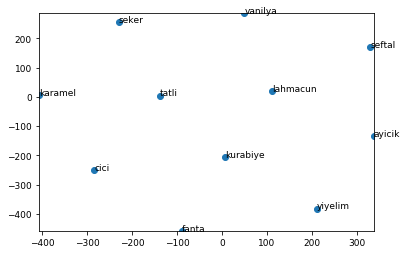

In [12]:
# MOST SIMILAR WORDS TO GIVEN WORD
word = input()
if word in doc2vec_model.wv:
    display_closestwords_tsnescatterplot(doc2vec_model, word, doc2vec_model.vector_size)
else:
    print("Not in vacobulary")

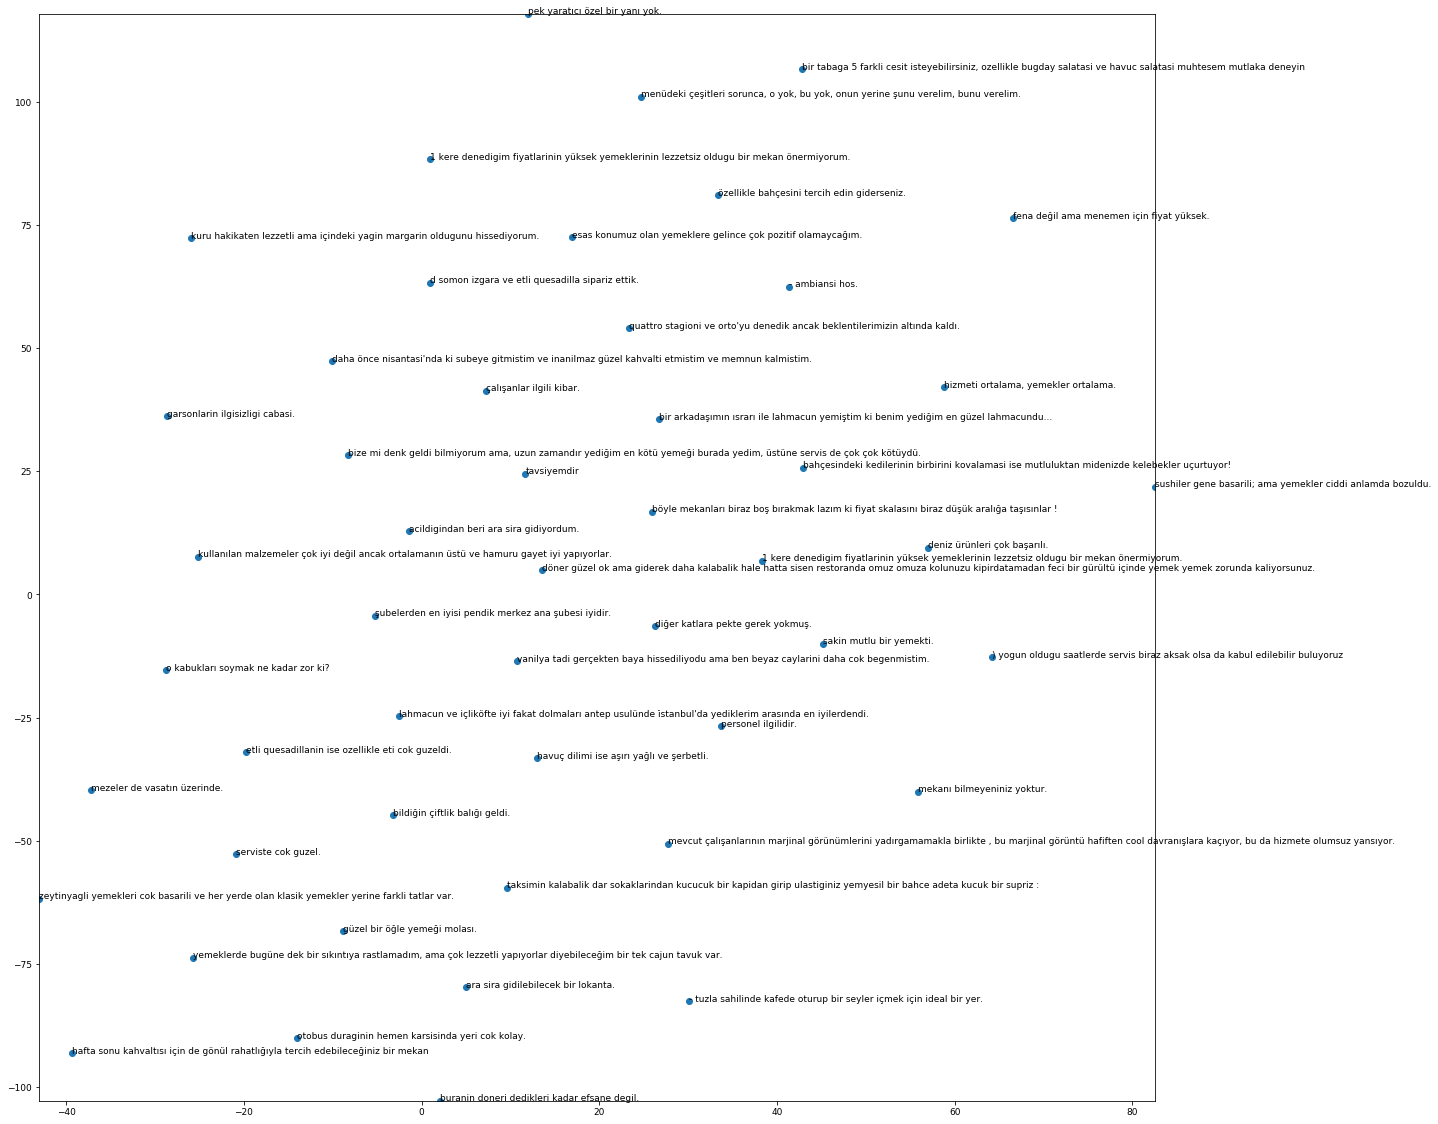

In [13]:
# PLOT DOCUMENTS WITH TSNE
arr = np.empty((0, doc2vec_model.vector_size), dtype='f')
doc_labels = []
for i in range(50):
    selected_doc_index = random.randrange(len(raw_reviews))
    doc2vec_label = "RESTAURANT_REVIEW_{}".format(selected_doc_index)
    arr = np.append(arr, np.array([doc2vec_model.docvecs["RESTAURANT_REVIEW_{}".format(i)]]), axis=0)
    doc_labels.append(raw_reviews[selected_doc_index])
    
# find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
plt.figure(1, figsize=(20,20))
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(doc_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

In [14]:
review_vectors = []
for i, review in enumerate(preprocessed_reviews):
    review_vectors.append(doc2vec_model.docvecs["RESTAURANT_REVIEW_{}".format(i)])

In [15]:
# CONSTRUCT DOC2VEC SIMILARITY MATRIX
doc2vec_adjacency_matrix = 1 - pairwise_distances(review_vectors, metric="cosine")
printmd("** DOC2VEC ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(doc2vec_adjacency_matrix.shape))
print(doc2vec_adjacency_matrix)

** DOC2VEC ADJACENCY MATRIX **

** Shape of adjacency the matrix: ** (1228, 1228)

[[ 1.          0.3785274  -0.04220355 ...  0.17803276  0.3369354
   0.43802494]
 [ 0.3785274   1.         -0.07357073 ...  0.40728563  0.83097756
   0.83774304]
 [-0.04220355 -0.07357073  1.         ... -0.04975724 -0.18678224
  -0.23294699]
 ...
 [ 0.17803276  0.40728563 -0.04975724 ...  1.          0.36507726
   0.45081377]
 [ 0.3369354   0.83097756 -0.18678224 ...  0.36507726  1.
   0.84638363]
 [ 0.43802494  0.83774304 -0.23294699 ...  0.45081377  0.84638363
   1.        ]]


In [47]:
# CREATE GRAPHS USING SIMILARITY MATRICES
def create_graph(adjacency_matrix, threshold=0.1, subsample_size=0):
    rows, cols = np.where(adjacency_matrix >= threshold)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    if subsample_size > 0:
        return gr.subgraph(list(range(subsample_size)))
    else:
        return gr

def get_meaningful_subgraph(G, n_nodes=20):
    G2 = G.subgraph(random.sample(list(range(0, len(G.nodes))), n_nodes))
    degrees = G2.degree()
    to_keep = [k for k, v in degrees if v > 2]
    G3 = G2.subgraph(to_keep)
    return G3.subgraph(to_keep)

In [17]:
# CREATE TF-IDF SIMILARITY GRAPH
tfidf_graph = create_graph(tfidf_adjacency_matrix, threshold=0.2)

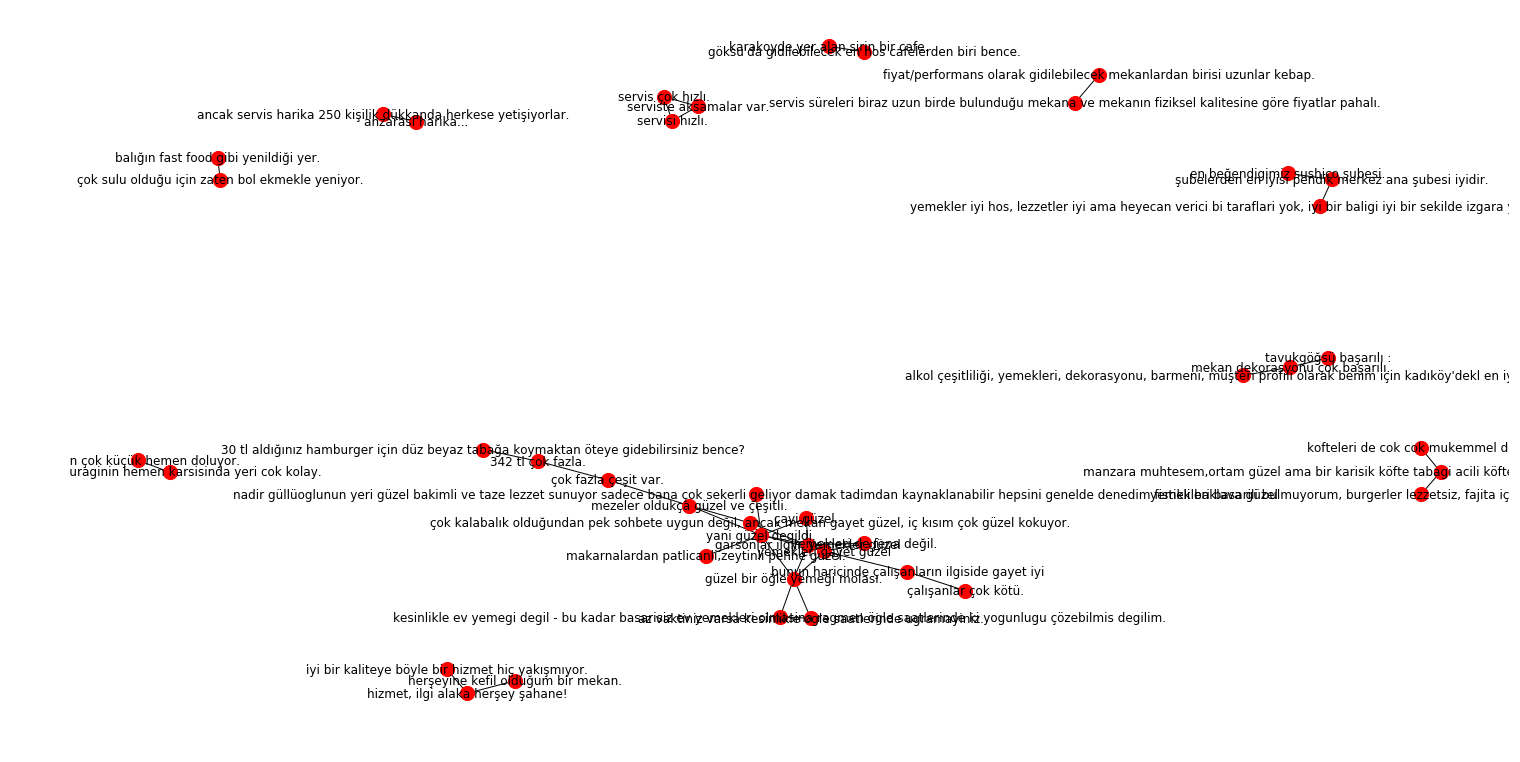

In [48]:
# PLOT SAMPLES IN TF-IDF SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(tfidf_graph, n_nodes=100)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(20,10))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

In [41]:
# CREATE AND PLOT DOC2VEC SIMILARITY GRAPH
doc2vec_graph = create_graph(doc2vec_adjacency_matrix, threshold=0.6)

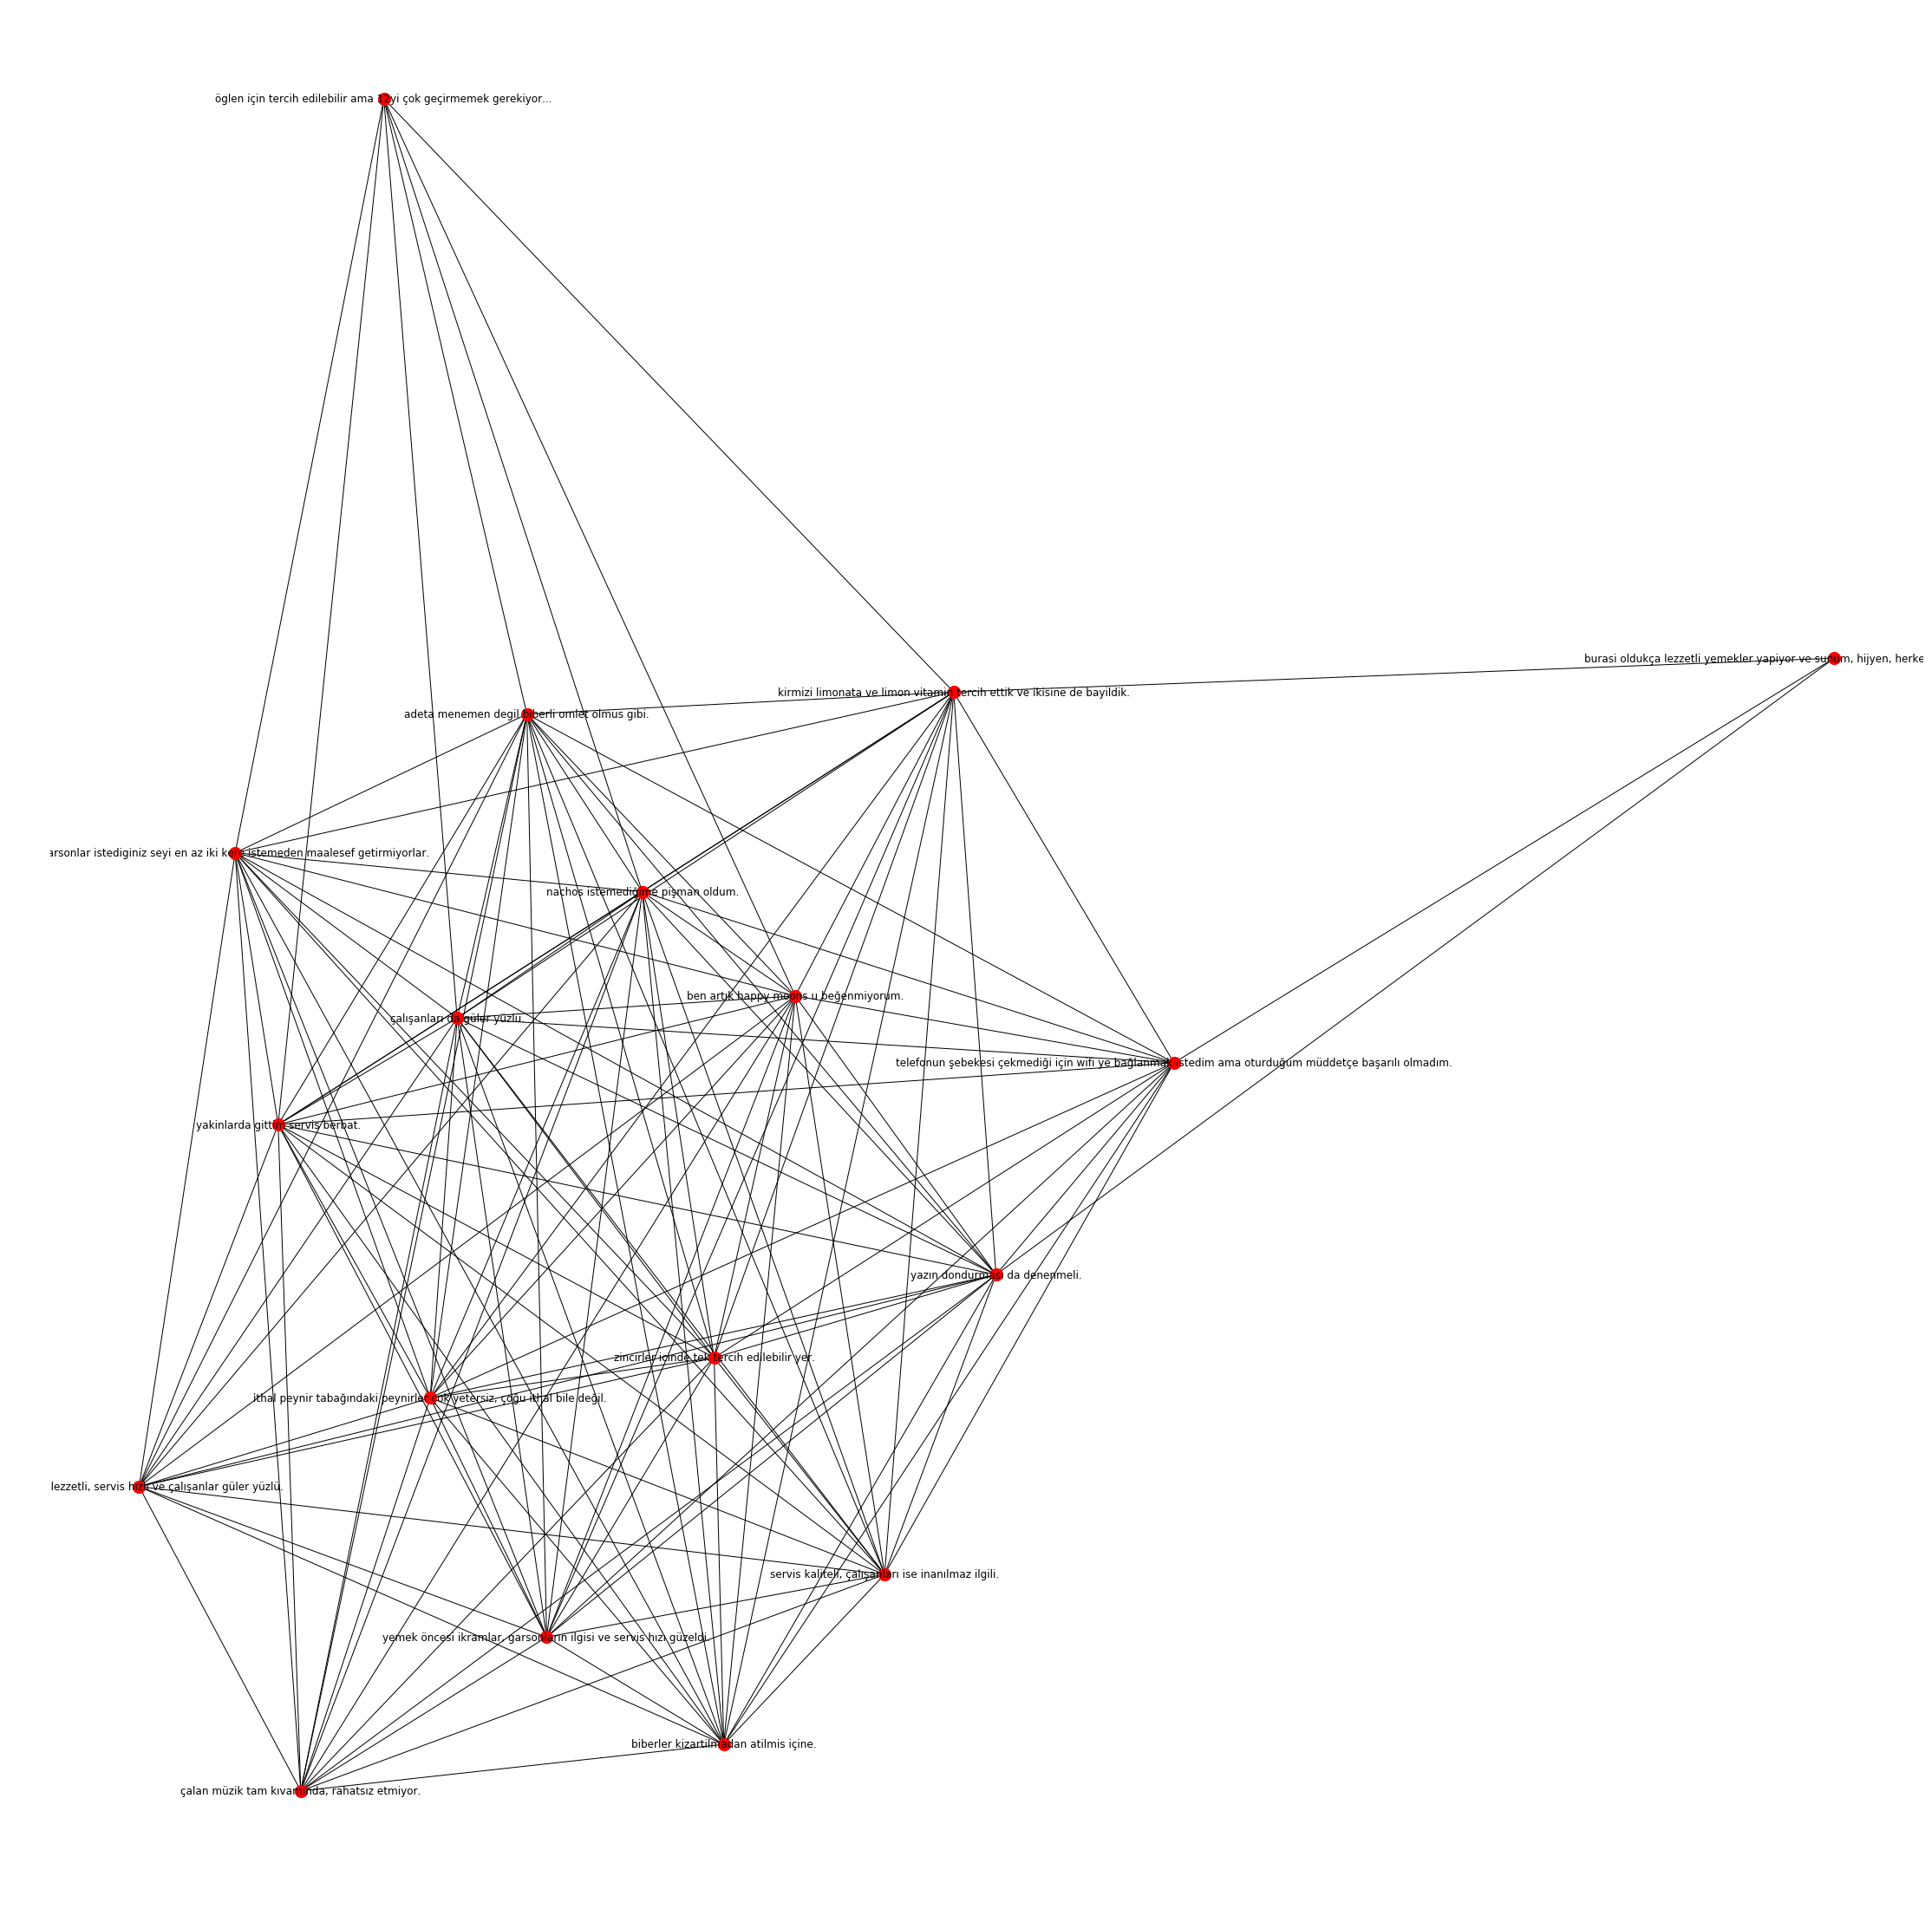

In [45]:
# PLOT SAMPLES IN DOC2VEC SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(doc2vec_graph)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(30,30))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

** METHOD: TF-IDF ** 


** Threshold: ** 0.1

** Average degree count ** 59.58688524590164

** Number of nodes without connection ** 8

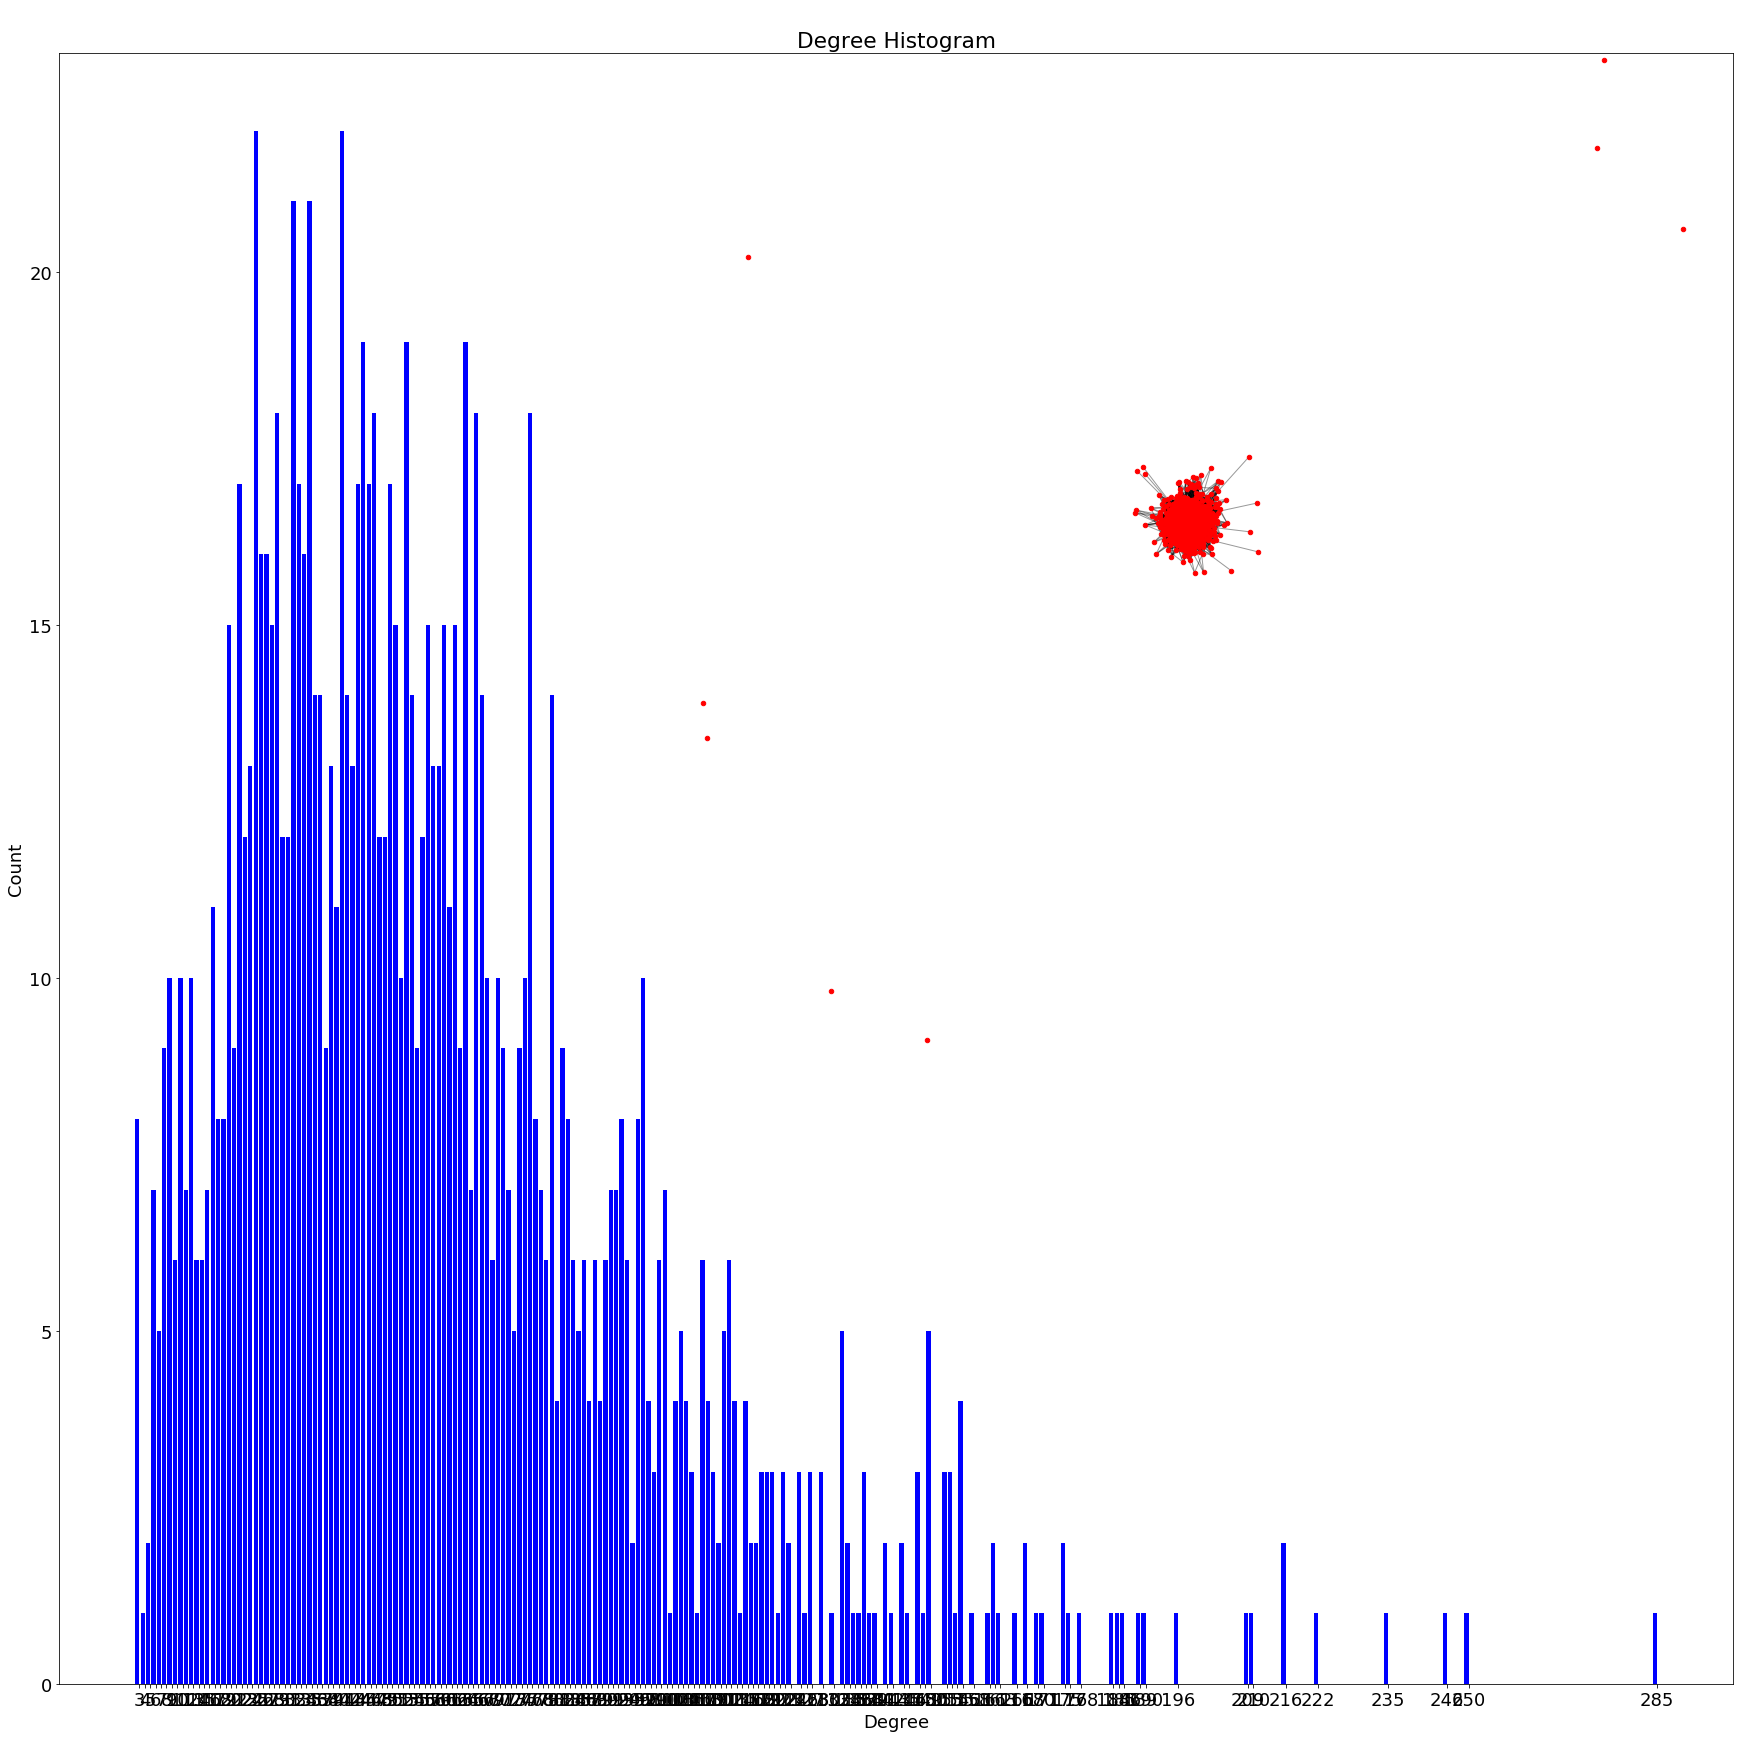

** METHOD: DOC2VEC ** 


** Threshold: ** 0.7

** Average degree count ** 498.3253493013972

** Number of nodes without connection ** 226

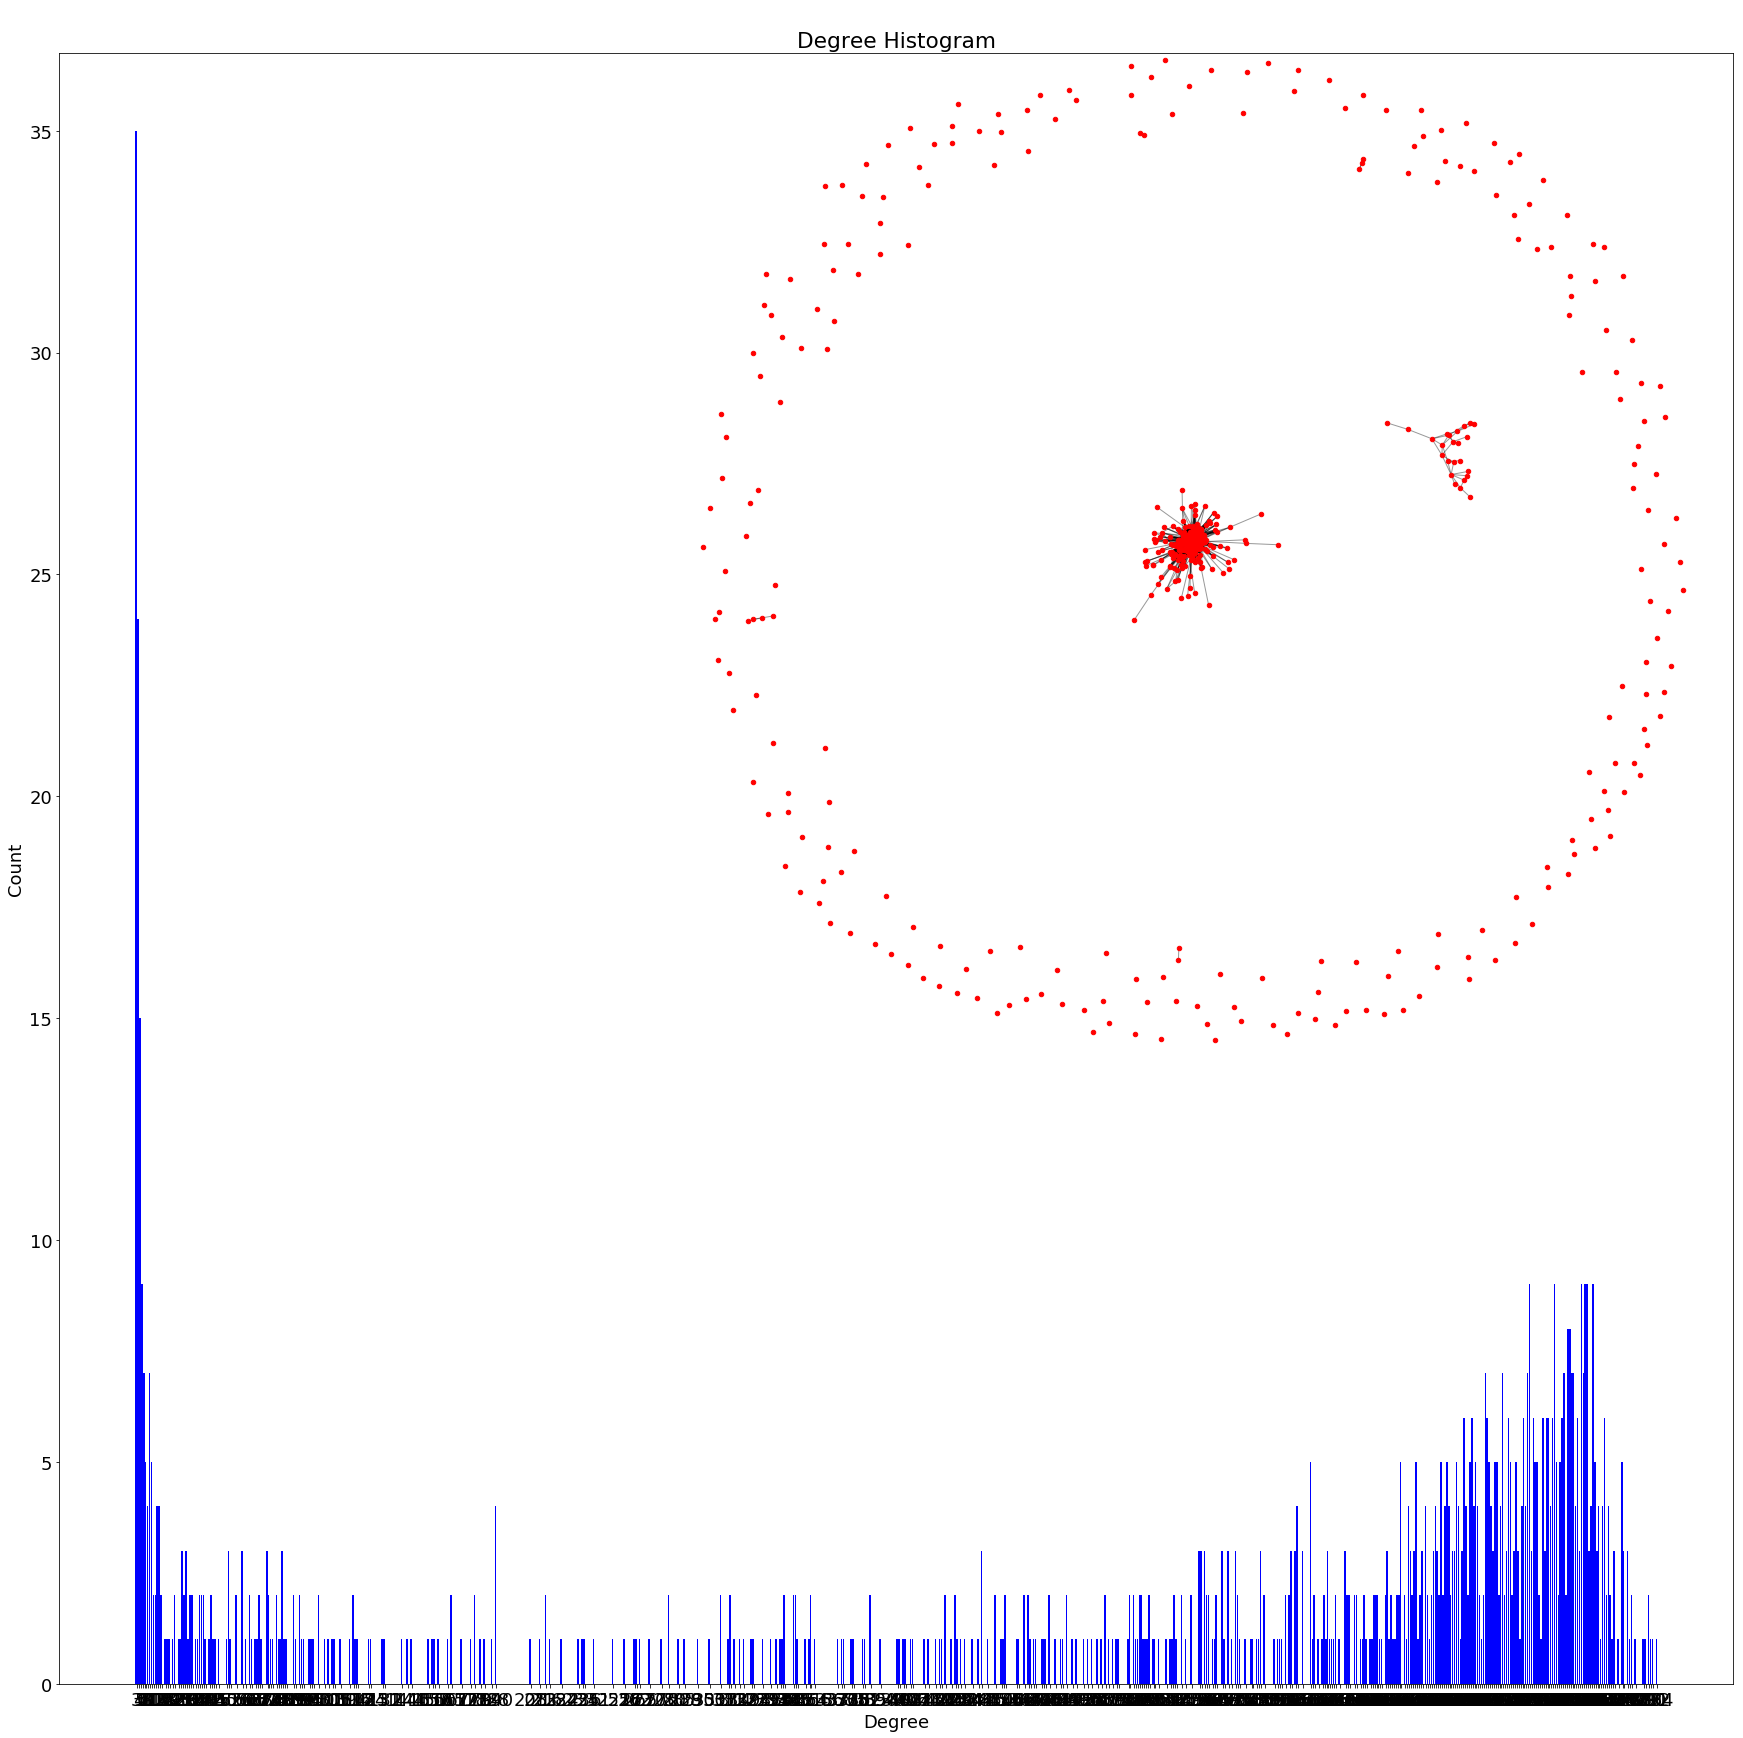

In [52]:
# PLOT DEGREE DISTRIBUTION OD TF_IDF AND DOC2VEC SIMILARITY GRAPHS WITH VARYING THRESHOLD VALUES
for i, adjacency_matrix in enumerate([tfidf_adjacency_matrix, doc2vec_adjacency_matrix]):
    if i == 0:
        printmd("** METHOD: TF-IDF ** \n")
        # thresholds = [0.1, 0.2, 0.3, 0.4]
        thresholds = [0.1]
    else:
        printmd("** METHOD: DOC2VEC ** \n")
        # thresholds = [0.5, 0.6, 0.7, 0.8]
        thresholds = [0.7]
    for threshold in thresholds:
        printmd("** Threshold: ** {}".format(threshold))
        graph = create_graph(adjacency_matrix, threshold=threshold)
        degree_sequence_whole_graph = sorted([d for n, d in graph.degree()], reverse=True)
        degree_sequence = sorted([d for n, d in graph.degree() if d > 2], reverse=True)  # degree sequence
        # print "Degree sequence", degree_sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots(figsize=(30, 30))
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        plt.axes([0.4, 0.4, 0.5, 0.5])
        Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)[0]
        pos = nx.spring_layout(graph)
        plt.axis('off')
        nx.draw_networkx_nodes(graph, pos, node_size=20)
        nx.draw_networkx_edges(graph, pos, alpha=0.4)
        printmd("** Average degree count ** {}".format(np.mean(degree_sequence)))
        printmd("** Number of nodes without connection ** {}".format(len([x for x in degree_sequence_whole_graph if x <= 2])))
        plt.show()

In [53]:
# CREATE PERSONALIZATION DICT FOR PERONILIZED PAGE RANK
def create_personalization_dic(label, num_seed=1, level="first"):
    personlization = {}
    num_found = 0
    for i, (cur_labels1, cur_labels2) in enumerate(zip(first_level_labels, second_level_labels)):
        personlization[i] = 0
        if num_found < num_seed:
            for label1, label2 in zip(cur_labels1, cur_labels2):
                if level == "first":
                    label_ = label1
                elif level == "second":
                    label_ = label1 + "\n" + label2
                else:
                    raise IOError("level parameter must be 'first' or 'second'!")
                if label == label_:
                    personlization[i] = 1
                    num_found += 1
                    #print("Seed Sentence_{}={}\nLabel={}".format(num_found, sentences[i], label))
                    break
    return personlization

In [60]:
# CALCULATE RANDOM BASELINES USING STANDARD PAGE RANK ALGORITHM

results_dic = {}
precisions = []
recalls = []
fs = []
threshold_for_labeling = 0.001
label_set = second_level_labels_set
label_counts = second_level_label_counts
for l in label_set:
    ppr1 = nx.pagerank(tfidf_graph, max_iter=100)
    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
    corrects = sum([1 for prediction in predictions
                    if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                    and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                   ])

    relevant_count = label_counts[l]
    prediction_count = len(predictions)
    if prediction_count == 0:
        precision = 1
    else:
        precision = (corrects * 1.0) / prediction_count
    if relevant_count == 0:
        recall = 1
    else:
        recall = (corrects * 1.0) / relevant_count
    if precision == 0 and recall == 0:
        f = 0.0
    else:
        f = 2 * precision * recall / (precision + recall)
    precisions.append(precision)
    recalls.append(recall)
    fs.append(f)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f = sum(fs) / len(fs)
random_base_line_result = {"Average F1 Score": average_f,
                           "Average Precision": average_precision,
                           "Average Recall": average_recall,
                           "Labeling Threshold": threshold_for_labeling,
                           "Number of labeled reviews": "N/A"
                          }
results_dic["Random baseline"] = random_base_line_result
random_base_line_result_df = pd.DataFrame.from_dict(results_dic)
display(HTML(random_base_line_result_df.to_html()))

,Random baseline
Average F1 Score,0.114697
Average Precision,0.104678
Average Recall,0.192193
Labeling Threshold,0.001
Number of labeled reviews,N/A


In [55]:
# EVALUATE PERFORMANCE, EXPERIMENTS WITH VARYING THRESHOLDS and METHODS
if not os.path.isfile("Results.xlsx"): 

    thresholds_to_eval = [[0.001, 0.0015, 0.002, 0.0025, 0.0030, 0.0035], 
                          [0.001, 0.003, 0.005, 0.007, 0.009]]

    num_seeds = [1, 5, 10, 20, 50]
    for method, thresholds_for_labeling in zip(["DOC2VEC", "TF-IDF"], thresholds_to_eval):
        for i, num_seed in enumerate(num_seeds):
            for j, threshold_for_labeling in enumerate(thresholds_for_labeling):
                print("Calculating {} of {}...".format(i * len(thresholds_for_labeling) + j, len(num_seeds) * len(thresholds_for_labeling)))

                precisions = []
                recalls = []
                fs = []
                label_set = second_level_labels_set
                label_counts = second_level_label_counts
                for l in label_set:
                    personalization = create_personalization_dic(l, num_seed=num_seed, level='second')
                    if method == "TF-IDF":
                        ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
                    else:
                        ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
                    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
                    corrects = sum([1 for prediction in predictions
                                    if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                                    and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                                   ])

                    relevant_count = label_counts[l]
                    prediction_count = len(predictions)
                    if prediction_count == 0:
                        precision = 1
                    else:
                        precision = (corrects * 1.0) / prediction_count
                    if relevant_count == 0:
                        recall = 1
                    else:
                        recall = (corrects * 1.0) / relevant_count
                    if precision == 0 and recall == 0:
                        f = 0.0
                    else:
                        f = 2 * precision * recall / (precision + recall)
                    precisions.append(precision)
                    recalls.append(recall)
                    fs.append(f)
                average_precision = sum(precisions) / len(precisions)
                average_recall = sum(recalls) / len(recalls)
                average_f = sum(fs) / len(fs)
                result = {"Average F1 Score": average_f,
                          "Average Precision": average_precision,
                          "Average Recall": average_recall,
                          "Labeling Threshold": threshold_for_labeling,
                          "Number of labeled reviews": num_seed
                         }
                results_dic["{}\n [Labeling Threshold={},\n Number of labeled reviews={}]"
                            .format(method, threshold_for_labeling, num_seed)] = result
    result_df = pd.DataFrame.from_dict(results_dic)
    result_df.to_excel("Results.xlsx")
else:
    result_df = pd.read_excel("Results.xlsx")
    display(HTML(result_df.to_html()))

,"DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=5]",Random baseline,"TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=5]"
Average F1 Score,0.251739,0.129572,0.407878,0.557877,0.259096,0.343095,0.113172,0.460800,0.660111,0.279561,0.366362,0.100908,0.500071,0.703789,0.264124,0.363741,0.100908,0.500503,0.709205,0.252888,0.363795,0.100908,0.500012,0.712201,0.252257,0.363795,0.100908,0.502643,0.677886,0.251714,0.114697,0.209470,0.141799,0.238351,0.30103

In [56]:
# SELECT BEST CONFIGURATION
best_tfidf_threshold = 0.0
best_doc2vec_threshold = 0.0
doc2vec_max_acc = 0.0
tf_idf_max_acc = 0.0
doc2vec_best_conf = ""
tfidf_best_conf = ""
for index, row in result_df.transpose().iterrows():
    conf_name = index
    if conf_name.startswith("TF-IDF") and row["Average F1 Score"] > tf_idf_max_acc:
        tf_idf_max_acc = row["Average F1 Score"]
        tfidf_best_conf = conf_name
        best_tfidf_threshold = row["Labeling Threshold"]
    elif row["Average F1 Score"] > doc2vec_max_acc:
        doc2vec_max_acc = row["Average F1 Score"]
        doc2vec_best_conf = conf_name
        best_doc2vec_threshold = row["Labeling Threshold"]

printmd("** Best threshold for Doc2Vec: ** {}".format(best_doc2vec_threshold))
printmd("** Best Doc2Vec Configuration: ** {}".format(doc2vec_best_conf))
printmd("** Best Doc2Vec F1 Score: ** {}".format(doc2vec_max_acc))
printmd("** Best threshold for TF-IDF: ** {}".format(best_tfidf_threshold))
printmd("** Best TF-IDF Configuration: ** {}".format(tfidf_best_conf))
printmd("** Best TF-IDF F1 Score: ** {}".format(tf_idf_max_acc))

** Best threshold for Doc2Vec: ** 0.003

** Best Doc2Vec Configuration: ** DOC2VEC
 [Labeling Threshold=0.003,
 Number of labeled reviews=50]

** Best Doc2Vec F1 Score: ** 0.712200616702579

** Best threshold for TF-IDF: ** 0.003

** Best TF-IDF Configuration: ** TF-IDF
 [Labeling Threshold=0.003,
 Number of labeled reviews=50]

** Best TF-IDF F1 Score: ** 0.526041971739432

In [111]:
result_df["DOC2VEC\n [Labeling Threshold=0.003,\n Number of labeled reviews=50]"]

Average F1 Score              0.712201
Average Precision             0.984499
Average Recall                0.651603
Labeling Threshold            0.003000
Number of labeled reviews    50.000000
Name: DOC2VEC\n [Labeling Threshold=0.003,\n Number of labeled reviews=50], dtype: float64

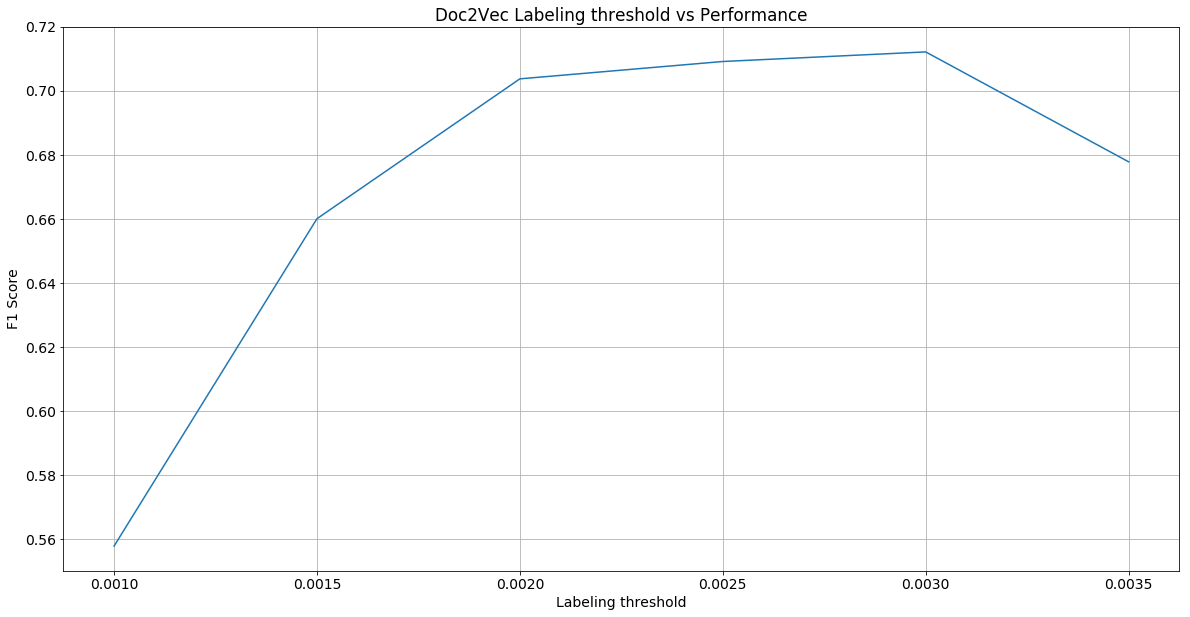

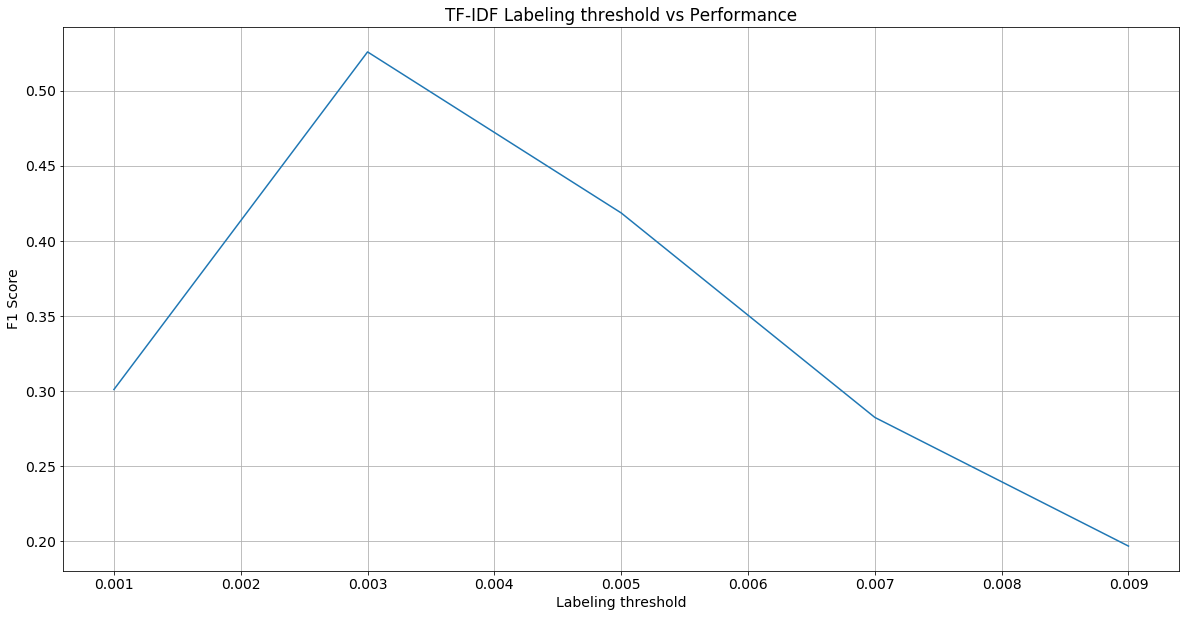

In [57]:
# Labeling Threshold - F Score plot 
doc2vec_threshold = []
doc2vec_f_scores = []
tf_idf_threshold = []
tf_idf_f_scores = []
for index, row in result_df.transpose().iterrows():
    conf_name = index
    conf_dic = row
    if conf_name.startswith("TF-IDF") and conf_dic["Number of labeled reviews"] == 50:
        if "first" not in conf_name:
            tf_idf_threshold.append(conf_dic["Labeling Threshold"])
            tf_idf_f_scores.append(conf_dic["Average F1 Score"])
    elif conf_dic["Number of labeled reviews"] == 50:
        if "first" not in conf_name:
            doc2vec_threshold.append(conf_dic["Labeling Threshold"])
            doc2vec_f_scores.append(conf_dic["Average F1 Score"])
tf_idf_threshold, tf_idf_f_scores = zip(*sorted(zip(tf_idf_threshold, tf_idf_f_scores)))
doc2vec_threshold, doc2vec_f_scores = zip(*sorted(zip(doc2vec_threshold, doc2vec_f_scores)))
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Doc2Vec Labeling threshold vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Labeling threshold")
plt.plot(doc2vec_threshold, doc2vec_f_scores)
# plt.plot(tf_idf_threshold, tf_idf_f_scores)
plt.grid(True)
plt.autoscale()
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("TF-IDF Labeling threshold vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Labeling threshold")
plt.plot(tf_idf_threshold, tf_idf_f_scores)
plt.grid(True)
plt.autoscale()

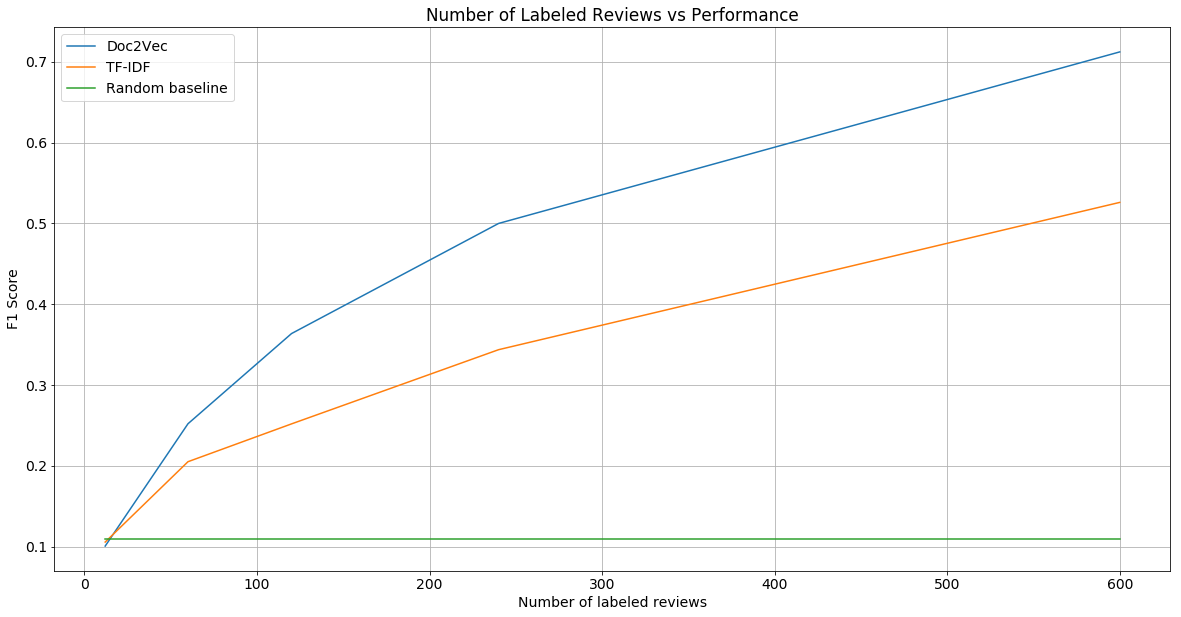

In [76]:
# Number of labeled reviews - F Score plot
doc2vec_num_seed = []
doc2vec_f_scores = []
tf_idf_num_seed = []
tf_idf_f_scores = []
for index, row in result_df.transpose().iterrows():
    conf_name = index
    conf_dic = row
    if conf_name.startswith("TF-IDF") and conf_dic["Labeling Threshold"] == best_tfidf_threshold:
        if "first" not in conf_name:
            tf_idf_num_seed.append(conf_dic["Number of labeled reviews"])
            tf_idf_f_scores.append(conf_dic["Average F1 Score"])
    elif conf_dic["Labeling Threshold"] == best_doc2vec_threshold:
        if "first" not in conf_name:
            doc2vec_num_seed.append(conf_dic["Number of labeled reviews"])
            doc2vec_f_scores.append(conf_dic["Average F1 Score"])
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Number of Labeled Reviews vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Number of labeled reviews")
doc2vec_num_seed, doc2vec_f_scores = zip(*sorted(zip(doc2vec_num_seed, doc2vec_f_scores)))
plt.plot(np.array(doc2vec_num_seed) * len(second_level_labels_set), doc2vec_f_scores)
tf_idf_num_seed, tf_idf_f_scores = zip(*sorted(zip(tf_idf_num_seed, tf_idf_f_scores)))
plt.plot(np.array(tf_idf_num_seed) * len(second_level_labels_set), tf_idf_f_scores)
plt.plot(np.array(tf_idf_num_seed) * len(second_level_labels_set), 
         len(tf_idf_num_seed) * [0.11])
# plt.yscale('log')
plt.grid(True)
plt.legend(['Doc2Vec', 
            'TF-IDF', 
            'Random baseline'
           ], loc='upper left')

In [63]:
# PREDICTIONS WITH BEST CONFIGURATION
num_seed = 50
method = "DOC2VEC"
threshold_for_labeling = best_doc2vec_threshold

model_outputs = []
label_set = second_level_labels_set
for raw_text, cur_labels1, cur_labels2 in zip(raw_reviews, first_level_labels, second_level_labels):
    model_outputs.append({"Text": raw_text, 
                          "Predicted labels": "",
                          "Gold labels": " ".join(
                              [cur_label1 + "/" + cur_label2
                               for cur_label1, cur_label2 in zip(cur_labels1, cur_labels2)]
                          )
                         })

for l in label_set:
    personalization = create_personalization_dic(l, num_seed=num_seed, level='second')
    if method == "TF-IDF":
        ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
    else:
        ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
    for prediction in predictions:
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"] + " " + l.replace("\n","/")
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"].strip()

model_predictions_df = pd.DataFrame.from_dict(model_outputs)
model_predictions_df.to_excel("Model Predictions.xlsx")
display(HTML(model_predictions_df.to_html()))

,Gold labels,Predicted labels,Text
0,AMBIENCE/GENERAL SERVICE/GENERAL,SERVICE/GENERAL AMBIENCE/GENERAL,manzara sahane evet ama servis rezalet.
1,FOOD/STYLE_OPTIONS SERVICE/GENERAL,SERVICE/GENERAL FOOD/STYLE_OPTIONS,"soguk su isteyince, soguk yok, butun sulari di..."
2,FOOD/QUALITY,FOOD/QUALITY,"yemekler iyi hos, lezzetler iyi ama heyecan ve..."
3,RESTAURANT/PRICES,RESTAURANT/PRICES,bu servise bu fiyatlar ise cok fazla.
4,RESTAURANT/GENERAL,RESTAURANT/GENERAL,lacivert beni kalitesinin dusukluguyle cok sas...
5,FOOD/QUALITY,RESTAURANT/MISCELLANEOUS DRINKS/PRICES FOOD/QU...,buraya bu kadar iyi yorum yapanlar her halde d...
6,SERVICE/GENERAL,SERVICE/GENERAL,kalamardan ve koladan önce balik geldi ve apar...
7,FOOD/QUALITY,FOOD/QUALITY,ayrica gelen kalamar soguk ve sünger gibiydi.
8,RESTAURANT/GENERAL,RESTAURANT/MISCELLANEOUS RESTAURANT/GENERAL,uzun lafin kisasi kesinlikle ve asla bir daha ...
9,RESTAURANT/GENERAL,RESTAURANT/GENERAL,daha önce de söyledigim gibi büyüdükçe kalites...
